# Filter File Production  for Trigger and Feature Processing


**In the notebook, we demonstrate how to produce of filter file for data processing of a continuous data. We calculate noise and generation functional form templates.**

We will do the following:
  * Use detprocess Noise class: produce PSD and CSD and save in filter file
  * Use detprocess Template class: produce templates and save in same filter file
  * Use detprocess FilterData class to load and check saved data
  


In [1]:
import warnings
warnings.filterwarnings('ignore')

# import Noise/Template class from detprocess
from detprocess import Noise, Template, FilterData

## Setup / Data Path

In [2]:
# continuous data directory
continuous_data = '/sdata2/runs/run34/raw/continuous_I2_D20231027_T184557'
series = None

# filter file
filter_file = '/sdata2/runs/run34/filterdata/detprocess_test_run34.hdf5'

# trace length 
# NOTE: different traces length can be use for each detectors or algorithms. 
# Noise and template length need to match and can be saved with different tag in same file
trace_length_msec = 20
pretrigger_length_msec = 10

## Noise PSD and CSD generation

### Instantiate detprocess Noise object

In [3]:
noise_inst = Noise(verbose=True)

### Generate  random events

Three ways of getting random events used to calculate noise PSD:
  1. generate randoms from continuous data
  2. set "randoms" vaex dataframe (produced by the processing or generated by Random object). Vaex dataframe can be either dataframe directly or full path to hdf5 file
  3. set randoms based on a list of events metadata. The list should follow format of detanalys.analyzer.get_event_list() function.

In [4]:
# Generate randoms
#  use either "random_rate" or nevents
#  you can specify minimum separation between randoms (default=100msec) and from/to the edge of 
# the continuous data
noise_inst.generate_randoms(continuous_data, series=series, nevents=2000, 
                       min_separation_msec=100, ncores=1)

INFO: Building file map for raw data group continuous_I2_D20231027_T184557
INFO: Total raw data duration = 180.0 minutes (1080 events)
INFO Node #1: Acquiring randoms for series I2_D20231027_T185208
INFO Node #1: Acquiring randoms for series I2_D20231027_T191830
INFO Node #1: Acquiring randoms for series I2_D20231027_T194453
INFO Node #1: Acquiring randoms for series I2_D20231027_T201117
INFO Node #1: Acquiring randoms for series I2_D20231027_T203739
INFO Node #1: Acquiring randoms for series I2_D20231027_T210401
INFO Node #1: Acquiring randoms for series I2_D20231027_T213025
INFO Node #1: Acquiring randoms for series I2_D20231027_T215647
INFO Node #1: Acquiring randoms for series I2_D20231027_T222310
INFO: Randoms acquisition done!


### Calculate PSD 

In [5]:
# let's calculate PSD for individual channels
# We need to specify trace length and pretrigger length (either in "samples" or "msec") 
# nevents used for calculation can be smaller than the genererate randoms
# a tag can be specified with argument "tag"

noise_inst.calc_psd(['Melange1pc1ch', 'Melange025pcLeft', 'Melange025pcRight'], 
                    trace_length_msec=trace_length_msec, 
                    pretrigger_length_msec=pretrigger_length_msec,
                    nevents=1000)

INFO: Processing PSD for channel Melange1pc1ch
INFO: 1000 events found in raw data for channel(s) Melange1pc1ch
INFO: Number of events after cuts = 202, efficiency = 20.20%
INFO: Processing PSD for channel Melange025pcLeft
INFO: 1000 events found in raw data for channel(s) Melange025pcLeft
INFO: Number of events after cuts = 270, efficiency = 27.00%
INFO: Processing PSD for channel Melange025pcRight
INFO: 1000 events found in raw data for channel(s) Melange025pcRight
INFO: Number of events after cuts = 391, efficiency = 39.10%


In [6]:
# let's calculate PSD for weighted sum of 2 channels: 'Melange025pcLeft+Melange025pcRight'
weights = {'Melange025pcLeft':0.9, 'Melange025pcRight':1.1}

noise_inst.calc_psd('Melange025pcLeft+Melange025pcRight', 
                    trace_length_msec=trace_length_msec, 
                    pretrigger_length_msec=pretrigger_length_msec,
                    nevents=1000,
                    weights=weights)

INFO: Processing PSD for channel Melange025pcLeft+Melange025pcRight
INFO: Number of events after cuts = 181, efficiency = 18.10%


In [7]:
# get psd

# only one channel
psd, psd_freqs = noise_inst.get_psd('Melange1pc1ch', fold=False)
print(psd.shape)

# or multiple channels
psd, psd_freqs = noise_inst.get_psd(['Melange1pc1ch', 
                                     'Melange025pcLeft+Melange025pcRight'], 
                                    fold=False)
print(psd.shape)

(25000,)
(2, 25000)


In [8]:
# sample rate (for later use)
fs = noise_inst.get_sample_rate()

#### Plot PSD(s)

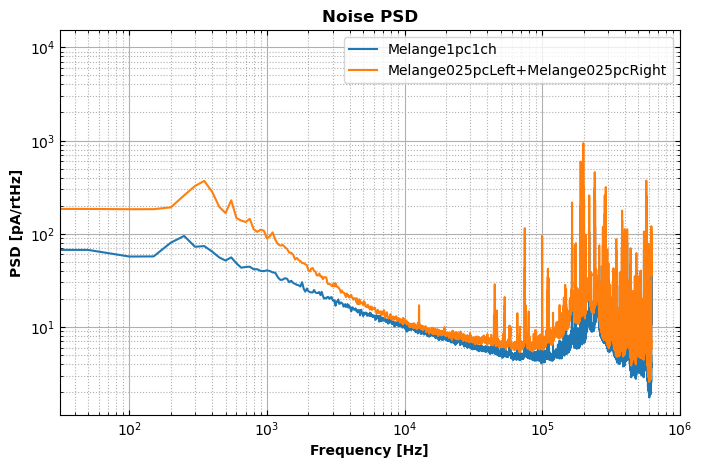

In [9]:
noise_inst.plot_psd(['Melange1pc1ch', 'Melange025pcLeft+Melange025pcRight'], 
                    unit='pA')

### Calculate CSD

The input channels can be either
 * a list such as **['channel1', 'channel2', 'channel3']**
 * or a string **'channel1|channel2|channel3'**
 
The index of the CSD follow order of the list or string!
 
The CSD is then stored in a dictionary and in hdf5 file with key = 'channel1|channel2|channel3' and can only be retrieved with the full name. 

In [10]:
channels_csd = 'Melange025pcLeft|Melange025pcRight'
# or equivalently use a list
#channels_csd = ['Melange025pcLeft','Melange025pcRight']

# NOTE: order is important as CSD index will follow channel order !!

In [11]:
noise_inst.calc_csd(channels_csd,
                    trace_length_msec=trace_length_msec, 
                    pretrigger_length_msec=pretrigger_length_msec,
                    nevents=1000)

INFO: Number of events after cuts = 188, efficiency = 18.80%


In [12]:
# get the csd array (use string or channel array)
csd, csd_freqs = noise_inst.get_csd(channels_csd)

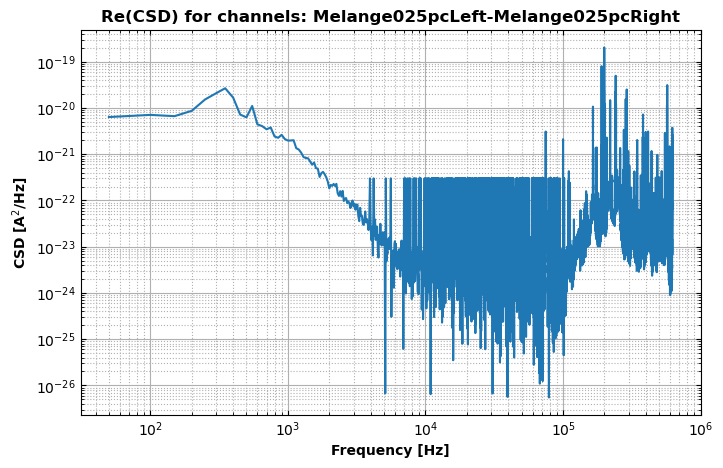

In [13]:
noise_inst.plot_csd(channels_csd, whichcsd=['01'])

#### Display correlation coeffcients from CSD

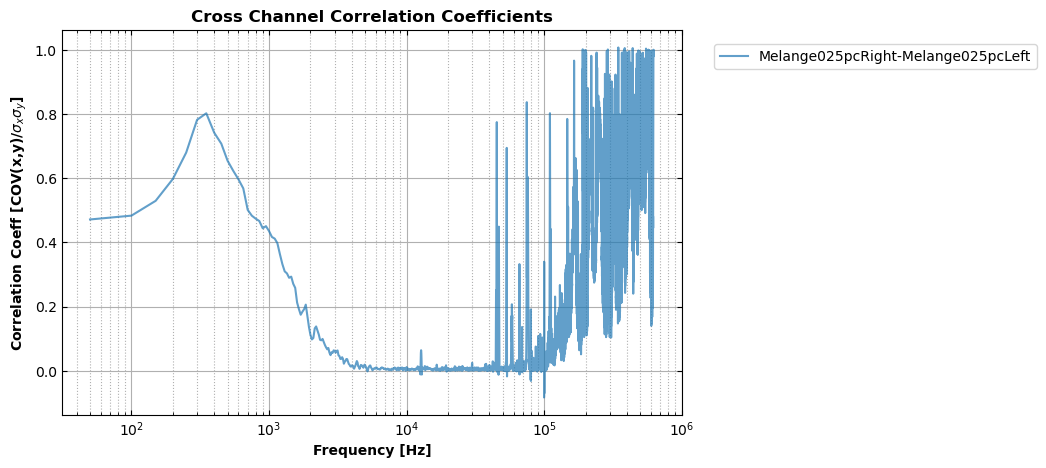

In [14]:
noise_inst.plot_corrcoeff(channels_csd)

### Save Noise to HDF5

In [16]:
noise_inst.save_hdf5(filter_file, overwrite=True)

INFO: Saving filter/TES data to file /sdata2/runs/run34/filterdata/detprocess_test_run34.hdf5! (overwrite=True)


## Template Generation

### Instantiate detprocess Template object

In [17]:
# instantiate template object
template_inst = Template()

###  Create templates for each channels

**NOTE: templates below are just for demo and not optimized!**

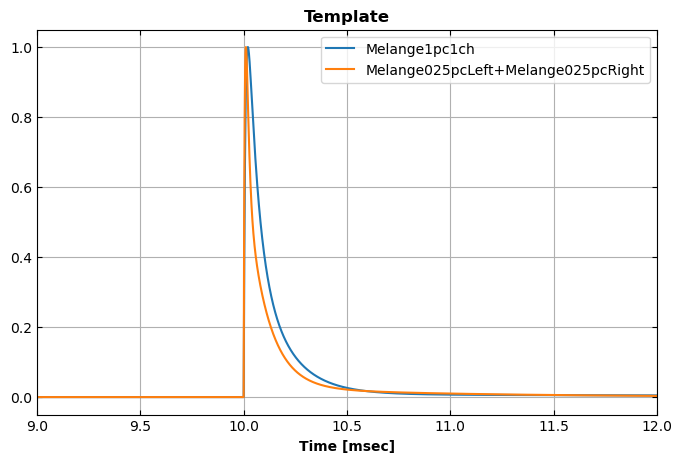

In [18]:
#  Melange 1% -> sum of 2-poles 
amplitudes = [1.67e-15, 1.32e-15, 2.39e-17]
fall_times = [44.6e-6, 147.5e-6, 3872.9e-6]
rise_times = [8.79e-6, 8.79e-6, 8.79e-6]

template_inst.create_template_sum_twopoles('Melange1pc1ch', 
                                           amplitudes, rise_times, fall_times,
                                           sample_rate=fs,
                                           trace_length_msec=trace_length_msec,
                                           pretrigger_length_msec=pretrigger_length_msec) 



#   Melange 0.25% Left and right -> sum of 2-poles 
#   For demo, just use same template shape for both channels 
amplitudes = [2.8e-15, 2.54e-15, 1.43e-16]
fall_times = [10.0e-6, 99.4e-6, 930.6e-6]
rise_times = [7.00e-6, 7.00e-6, 7.00e-6]

template_inst.create_template_sum_twopoles(['Melange025pcLeft','Melange025pcRight', 
                                            'Melange025pcLeft+Melange025pcRight'], 
                                           amplitudes, rise_times, fall_times,
                                           sample_rate=fs,
                                           trace_length_msec=trace_length_msec,
                                           pretrigger_length_msec=pretrigger_length_msec) 



# get templates array, exmpple
template_melange1pc1ch, time_array = template_inst.get_template('Melange1pc1ch')


# display
template_inst.plot_template(['Melange1pc1ch', 'Melange025pcLeft+Melange025pcRight'], 
                            xmin=9, xmax=12)


### Save templates to filter file

In [20]:
template_inst.save_hdf5(filter_file, overwrite=True)

INFO: Saving filter/TES data to file /sdata2/runs/run34/filterdata/detprocess_test_run34.hdf5! (overwrite=True)


## Load Filter file with FilterData

In [21]:
filterdata_inst = FilterData()
filterdata_inst.load_hdf5(filter_file)
filterdata_inst.describe()

INFO: Loading filter data from file /sdata2/runs/run34/filterdata/detprocess_test_run34.hdf5
List of channels: ['Melange1pc1ch', 'Melange025pcRight', 'Melange025pcLeft+Melange025pcRight', 'Melange025pcLeft|Melange025pcRight', 'Melange025pcLeft']

Channel Melange1pc1ch:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)

Channel Melange025pcRight:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)

Channel Melange025pcLeft+Melange025pcRight:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)

Channel Melange025pcLeft|Melange025pcRight:
 * Tag "default":
    csd: 3D numpy.array  (2, 2, 25000)
 * Tag "freqs_default":
    csd: pandas.Series (25000,)

Channel Melange025pcLeft:
 * Tag "default":
    psd: pandas.Series (25000,)
    template: pandas.Series (25000,)
